## Import base fire perimeter map

In [7]:
## Note: The following packages must be installed:
# pip install geopandas pandas matplotlib requests jupyter ipykernel contextily

import geopandas as gpd

In [8]:
# initialize the geodataframe, select fire perimeters. For prescribed burns, select "rxburn24_1" instead of "firep24_1"
gdf = gpd.read_file("../data/raw/fire24_1.gdb", layer="firep24_1")
print(gdf.shape) #Geodataframe dimensions
print(gdf.crs) #Coordinate reference system - EPSG 3310 = California Albers projection
print(gdf.columns.tolist())

(22810, 20)
EPSG:3310
['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'IRWINID', 'ALARM_DATE', 'CONT_DATE', 'C_METHOD', 'CAUSE', 'COMPLEX_NAME', 'COMPLEX_ID', 'OBJECTIVE', 'GIS_ACRES', 'COMMENTS', 'FIRE_NUM', 'Shape_Length', 'Shape_Area', 'geometry']


<Axes: >

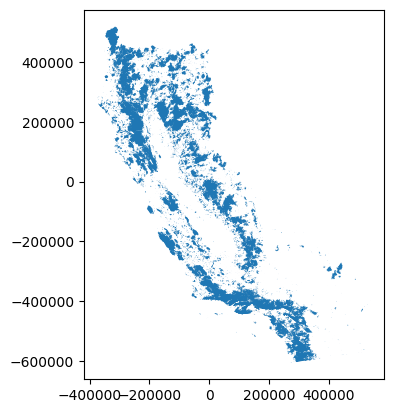

In [9]:
gdf.plot()

### Import base map

In [10]:
import contextily as ctx
import matplotlib.pyplot as plt

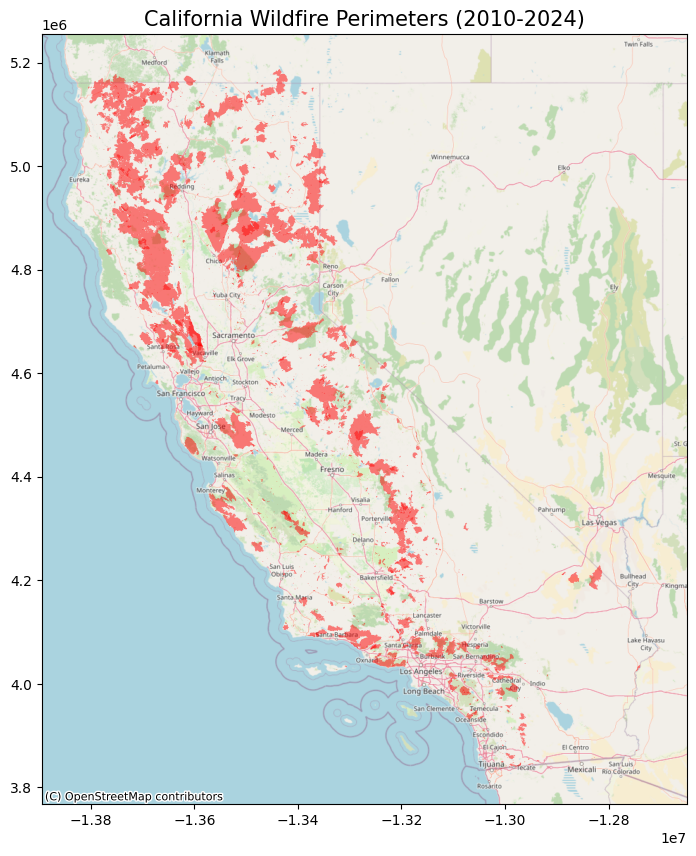

In [11]:
# Filter basemap to 2010 fires and onward
gdf_recent = gdf[gdf['YEAR_'] >= 2010]

# Convert CRS to Web Mercator for contextily basemap
gdf_web = gdf_recent.to_crs(epsg=3857)

# Plot the fire perimeters
fig, ax= plt.subplots(figsize=(10,10))
gdf_web.plot(ax=ax, alpha=0.5, color="red")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("California Wildfire Perimeters (2010-2024)", fontsize=15)
plt.show()

Add interactivity via ipywidgets for quick analyses

In [12]:
# Enter the following into Bash terminal:
# pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display

In [13]:
def plot_year(year):
    gdf_year = gdf[gdf['YEAR_'] == year].to_crs(epsg=3857)
    fig, ax = plt.subplots(figsize=(10,10)) #Initialize new dataset to matching years only, then create new canvas for each year
    gdf_year.plot(ax=ax, alpha=0.5, color="red")
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    plt.title(f"California Wildfire Perimeters - {year}", )
    plt.show()

widgets.interact(plot_year, year=widgets.IntSlider(
    min=2010, max=2024, step=1, value=2010))



interactive(children=(IntSlider(value=2010, description='year', max=2024, min=2010), Output()), _dom_classes=(…

<function __main__.plot_year(year)>

## Create Choropleth Map

f:\GeoPandas Projects\ca-wildfire-project\venv\Lib\site-packages\geopandas\geodataframe.py:257: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)
f:\GeoPandas Projects\ca-wildfire-project\venv\Lib\site-packages\geopandas\geodataframe.py:257: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


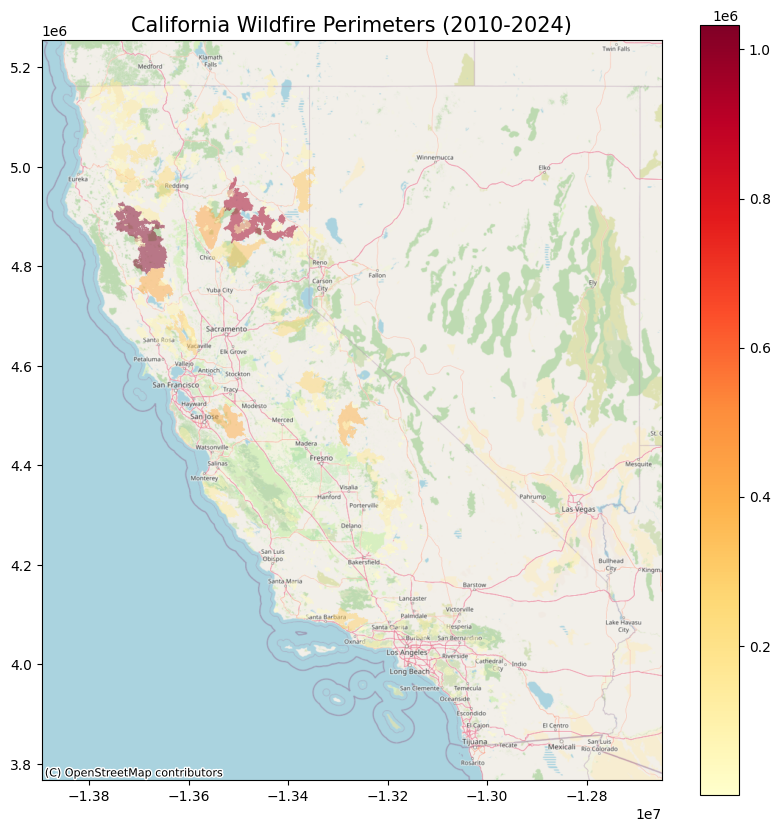

In [ ]:
gdf_recent = gdf[gdf['YEAR_'] >= 2010]
gdf_web = gdf_recent.to_crs(epsg=3857)
fig, ax= plt.subplots(figsize=(10,10))

# Changing column output to acreage and mapping to a gradient color scheme
gdf_web.plot(ax=ax, alpha=0.5, column="GIS_ACRES", cmap="YlOrRd", legend=True)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("California Wildfire Perimeters (2010-2024)", fontsize=15)
plt.show()

### Normalize with log scale via Matplotlib with LogNorm

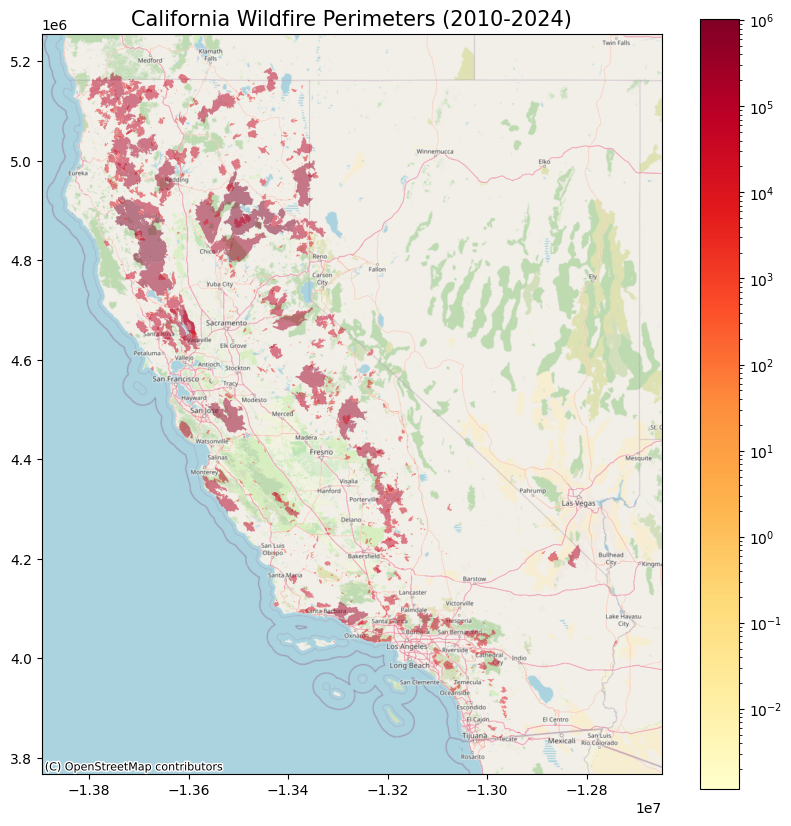

In [15]:
from matplotlib.colors import LogNorm

gdf_recent = gdf[gdf['YEAR_'] >= 2010]
gdf_web = gdf_recent.to_crs(epsg=3857)
fig, ax= plt.subplots(figsize=(10,10))
gdf_web.plot(ax=ax, alpha=0.5, column="GIS_ACRES", cmap="YlOrRd", legend=True,
# Use logarithmic normalization for better color distribution
norm=LogNorm(vmin=gdf_web['GIS_ACRES'].min(), vmax=gdf_web['GIS_ACRES'].max())
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("California Wildfire Perimeters (2010-2024)", fontsize=15)
plt.show()

## Data Exploration

In [11]:
gdf['CAUSE'].value_counts()

CAUSE
14    10316
1      3548
9      3507
2      1391
7       987
5       782
10      597
11      480
4       401
3       341
8       197
18      104
6        79
15       30
19       17
16       15
13       13
12        5
Name: count, dtype: int64

The CAL FIRE Cause Code Legend is as follows:
Code	Cause
1	Lightning
2	Equipment Use
3	Smoking
4	Campfire
5	Debris Burning
6	Railroad
7	Arson
8	Playing with Fire
9	Miscellaneous
10	Vehicle
11	Power Line
12	Firefighter Training
13	Non-Firefighter Training
14	Unknown
15	Structure
16	Aircraft
18	Escaped Prescribed Burn
19	Illegal Alien Campfire

In [12]:
gdf['AGENCY'].value_counts()

AGENCY
USF    9692
CDF    7211
CCO    3580
NPS    1048
BLM     747
LRA     212
DOD     168
FWS      84
BIA      18
OTH       1
Name: count, dtype: int64

CAL FIRE Agency Codes:
Code	Agency
USF	US Forest Service (federal)
CDF	CAL FIRE (state) — older name before rebranding
CCO	Contract County — county-level fire agencies
NPS	National Park Service
BLM	Bureau of Land Management
LRA	Local Responsibility Area
DOD	Department of Defense
FWS	Fish & Wildlife Service
BIA	Bureau of Indian Affairs
OTH	Other

In [13]:
gdf['CONT_DATE'].isna().sum()


np.int64(12630)

In [14]:
gdf['ALARM_DATE'].isna().sum()


np.int64(5396)

In [15]:
fire_duration = gdf['CONT_DATE'] - gdf['ALARM_DATE']
print(fire_duration)

0       24 days
1       23 days
2        6 days
3       26 days
4        2 days
          ...  
22805       NaT
22806       NaT
22807       NaT
22808       NaT
22809       NaT
Length: 22810, dtype: timedelta64[ms]


In [16]:
fire_duration.describe()

count                      10170
mean      8 days 21:01:18.584000
std      40 days 21:46:19.883000
min          -271 days +00:00:00
25%              0 days 00:00:00
50%              1 days 00:00:00
75%              4 days 00:00:00
max           3319 days 00:00:00
dtype: object

At a quick glance, we can see the majority of the data is sound, but there are some serious outliers that will need to be cleaned up prior to analysis. Most notably...

    min = -271 days — negative duration means some fires have a containment date before their alarm date. That's impossible and is a data quality error — likely data entry mistakes in the source dataset

    max = 3,319 days — that's over 9 years. Almost certainly another data error

    25% = 0 days — a quarter of fires show zero duration, meaning alarm and containment date are the same day. Could be real (immediate containment) or could be date precision issues.

## Data Analysis: Top 10 Largest Fires

In [ ]:
top10 = gdf_recent.nlargest(10, 'GIS_ACRES')
top10[['FIRE_NAME', 'YEAR_', 'GIS_ACRES']]

,FIRE_NAME,YEAR_,GIS_ACRES
1532,AUGUST COMPLEX,2020.0,1.032700e+06
1144,DIXIE,2021.0,9.634054e+05
6,PARK,2024.0,4.296028e+05
2354,RANCH,2018.0,4.102025e+05
1533,SCU LIGHTNING COMPLEX,2020.0,3.968245e+05
1534,CREEK,2020.0,3.798424e+05
1535,NORTH COMPLEX,2020.0,3.187972e+05
4586,RUSH,2012.0,3.155115e+05
1536,HENNESSEY,2020.0,3.053519e+05
2770,THOMAS,2017.0,2.817909e+05


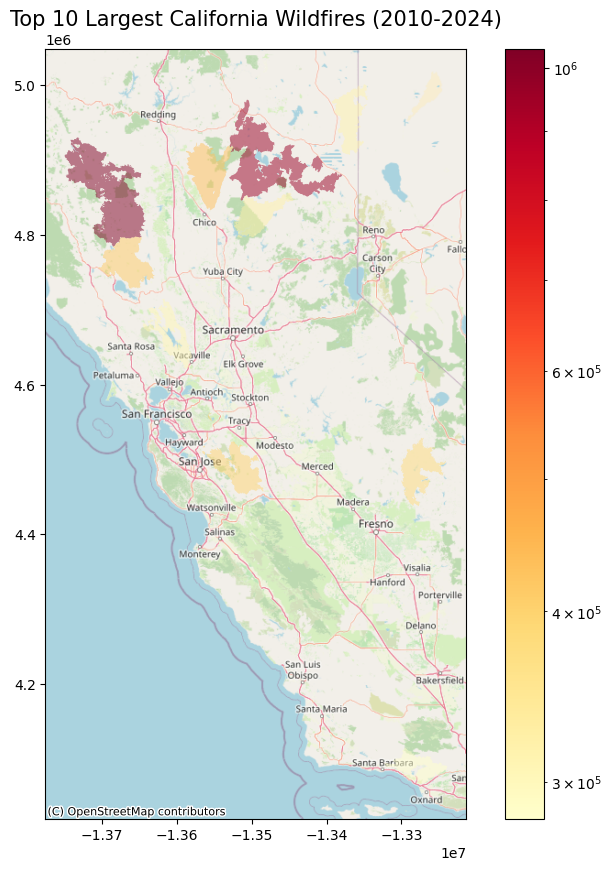

In [18]:
top10 = top10.to_crs(epsg=3857)
fig, ax= plt.subplots(figsize=(10,10))
top10.plot(ax=ax, alpha=0.5, column="GIS_ACRES", cmap="YlOrRd", legend=True,
norm=LogNorm(vmin=top10['GIS_ACRES'].min(), vmax=top10['GIS_ACRES'].max()))
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Top 10 Largest California Wildfires (2010-2024)", fontsize=15)
plt.show()

## Adding State Boundary Layers

<Axes: >

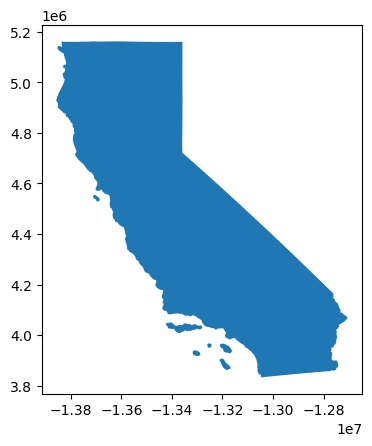

In [32]:
## Loading shapefile from census.gov

gdf_states =gpd.read_file("../data/raw/tl_2023_us_state.shp")
ca_bounds = gdf_states[gdf_states['NAME'] == 'California']
# reconfiguring crs to EPSG 3857 for plotting with fire map
ca_bounds = ca_bounds.to_crs(epsg=3857)
ca_bounds.plot()

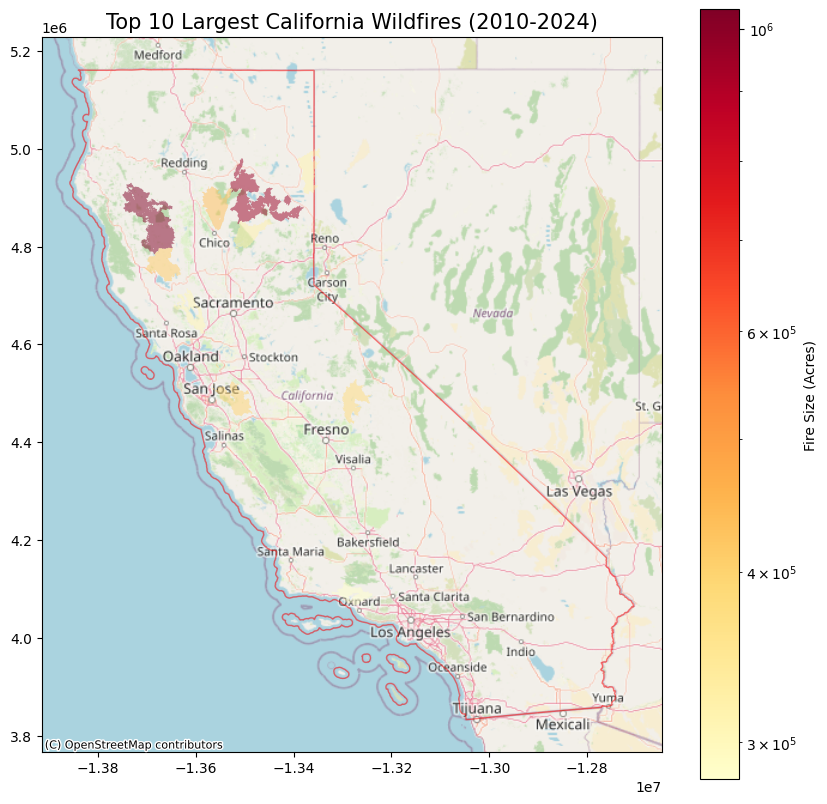

In [ ]:
# Create California boundary plot with top 10 fires overlaid
fig, ax= plt.subplots(figsize=(10,10))
ca_bounds.plot(ax=ax, alpha=0.5, facecolor="none", edgecolor="red", linewidth=1)
top10.plot(ax=ax, alpha=0.5, column="GIS_ACRES", cmap="YlOrRd", legend=True, legend_kwds={'label': "Fire Size (Acres)"},
norm=LogNorm(vmin=top10['GIS_ACRES'].min(), vmax=top10['GIS_ACRES'].max()))
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Top 10 Largest California Wildfires (2010-2024)", fontsize=15)
plt.show()